# **Team 16 - EDSA movie recommendation wilderness**

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://storage.googleapis.com/kaggle-competitions/kaggle/33594/logos/header.png?t=2022-01-04-10-31-44")

#### Installations

In [2]:
!pip install scikit-plot

You should consider upgrading via the 'c:\users\henri\anaconda3\python.exe -m pip install --upgrade pip' command.


#### Start Comet Experiment

In [3]:
#Uncomment the below to create/start a new experiment on Comet

"""# Start Comet Experiment
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="0PXFIXjRITl64S9L8bH64cfYP",
    project_name="unsupervised-learning-predict",
    workspace="henriedwards",
)"""

'# Start Comet Experiment\nfrom comet_ml import Experiment\n\n# Create an experiment with your api key\nexperiment = Experiment(\n    api_key="0PXFIXjRITl64S9L8bH64cfYP",\n    project_name="unsupervised-learning-predict",\n    workspace="henriedwards",\n)'

<a id="cont"></a>

### Table of Contents

<a href=#one>1. Problem Statement</a>

<a href=#two>2. Importing Libraries</a>

<a href=#three>3. Loading Data</a>

<a href=#four>4. Data Preprocessing</a>

<a href=#five>5. Exploratory Data Analysis</a>

<a href=#six>6. Content Based Filtering</a>

<a href=#sevem>7. Collaborative Filtering</a>

<a href=#eight>8. Model Evaluation</a>

<a href=#nine>9. Hyperparameter Tuning</a>

<a href=#ten>10. Conclusion</a>

<a href=#eleven>11. Submission</a>

<a id="one"></a>
## 1. Problem Statement

We are tasked to construct a recommendation algorithm, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences. To achieve this, we will contruct both a Content-Based filtering & Collaborative Filtering Recommender Systems.

<a id="two"></a>
## 2. Importing Libraries

In [4]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Kaggle requirements
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data analysis libraries
import pandas as pd
import numpy as np        
        
# ML Pre processing
import re
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from numpy.random import RandomState
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualisation libraries
from matplotlib import pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
sns.set()

# Content Filtering Models
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Suprise
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split

# Collaborative Filtering
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

# Evaluation
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise.accuracy import rmse
from surprise import accuracy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Hyperparameter tuning
from surprise.model_selection import GridSearchCV

<a id="three"></a>
## 3. Loading Data

In [5]:
movies = pd.read_csv("movies.csv")
movies_og = pd.read_csv("movies.csv")
imdb_data = pd.read_csv("imdb_data.csv")
genome_tags = pd.read_csv("genome_tags.csv")
genome_scores = pd.read_csv("genome_scores.csv")
tags = pd.read_csv("tags.csv")
links = pd.read_csv("links.csv")
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


<a id="four"></a>
## 4. Data Preprocessing

**Data preview**

In [6]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [7]:
imdb_data.head(3)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry


In [8]:
genome_tags.head(3)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century


In [9]:
genome_scores.head(3)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250


In [10]:
tags.head(3)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598


In [11]:
links.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [12]:
train_data.head(3)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539


In [13]:
# check duplicates
dup_bool = train_data.duplicated(['userId', 'movieId', 'rating', 'timestamp'])

# display duplicates
print("Number of duplicate records:", sum(dup_bool))

Number of duplicate records: 0


In [14]:
# fill NaN values with usable nulls

imdb_data['director'] = imdb_data['director'].fillna('')
imdb_data['runtime'] = imdb_data['runtime'].fillna('')
imdb_data['budget'] = imdb_data['budget'].fillna('')
imdb_data['title_cast'] = imdb_data['title_cast'].fillna('')
imdb_data['plot_keywords'] = imdb_data['plot_keywords'].fillna('')

In [15]:
# remove string seperators and add to a list

imdb_data['plot_keywords'] = imdb_data['plot_keywords'].str.split('|')
imdb_data['title_cast'] = imdb_data['title_cast'].str.split('|')
movies['genres'] = movies['genres'].str.split('|')

In [16]:
# extract year from title into own feature

movies['year'] = movies['title'].str.extract('(\d{4})')

In [17]:
def year_remover(text):
    
    """Function that takes in a string, and removes the year in parenthesis"""
    
    text = re.sub(r'\([^)]*\)','',text)
    return text

movies['title'] = movies['title'].map(year_remover)

In [18]:
movies.head(3)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995


<a id="five"></a>
## 5. Exploratory Data Analysis (EDA)
Within our EDA we will use numerous visualization techniques to attempt to extract any insights from the data.
- Movies
- Genres
- Cast
- Directors
- Plot Keywords
- Ratings
- Budget

### **Movies**

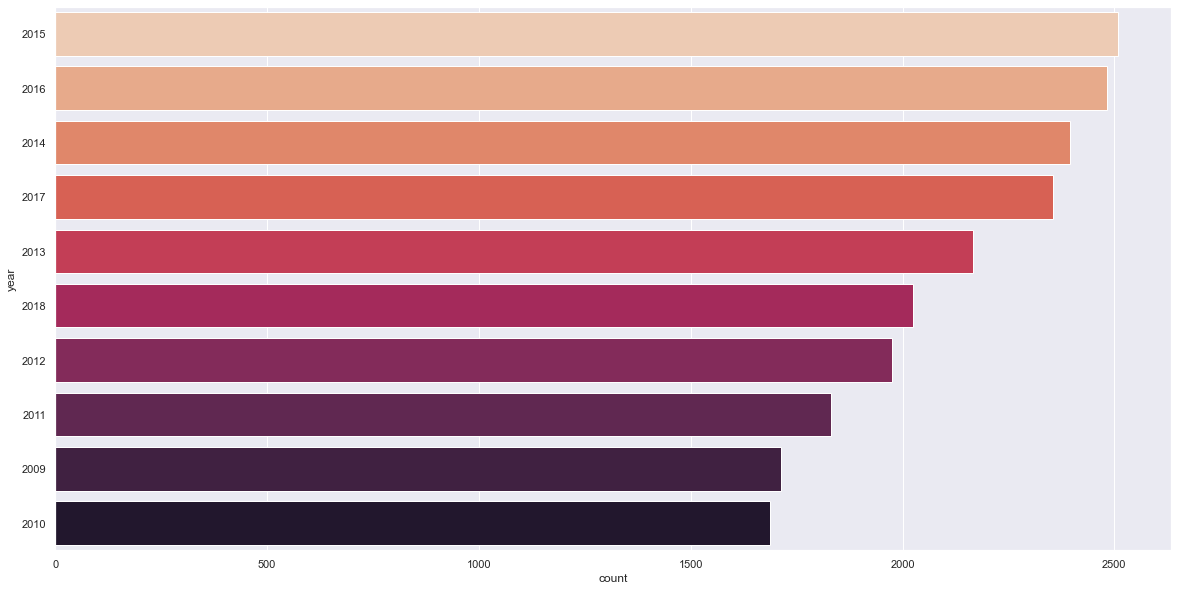

In [19]:
plt.subplots(figsize=(20,10))
sns.set(style="white")
ax = sns.countplot(y="year", data=movies, palette="rocket_r", order=movies['year'].value_counts().index[0:10])

### **Genres**

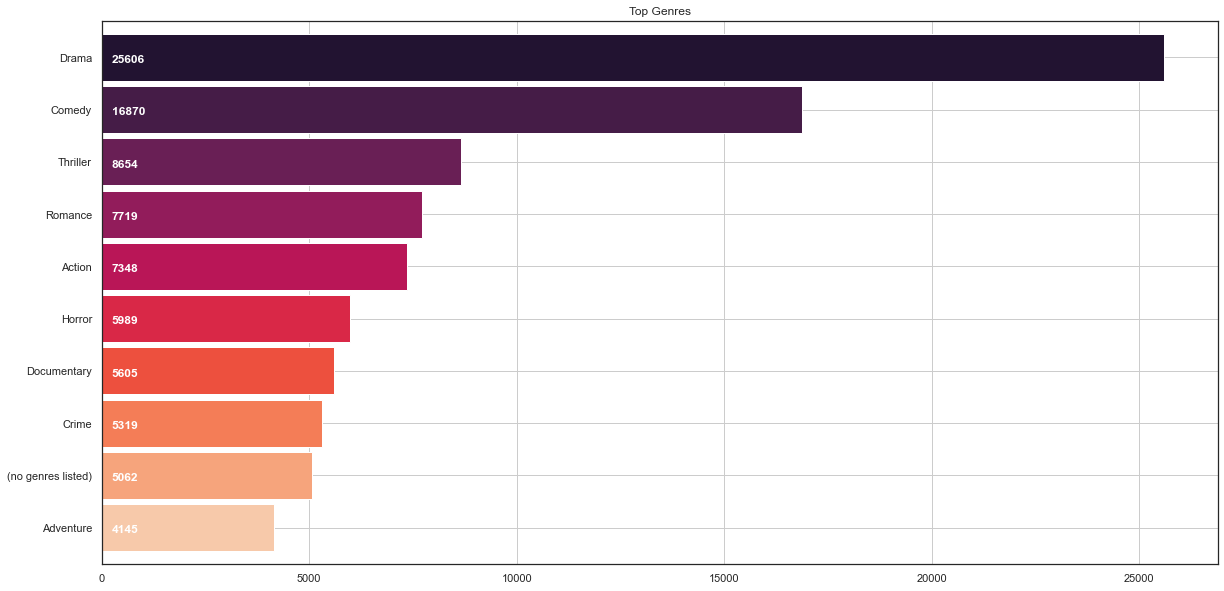

In [20]:
# Plot Distribution of Genres

plt.subplots(figsize=(20,10))
list1 = []
sns.set(style='whitegrid', palette='flare',
        rc={'figure.figsize': (6,10)})

for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('rocket_r',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(250, i-.10, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

### **Genres - Wordcloud**

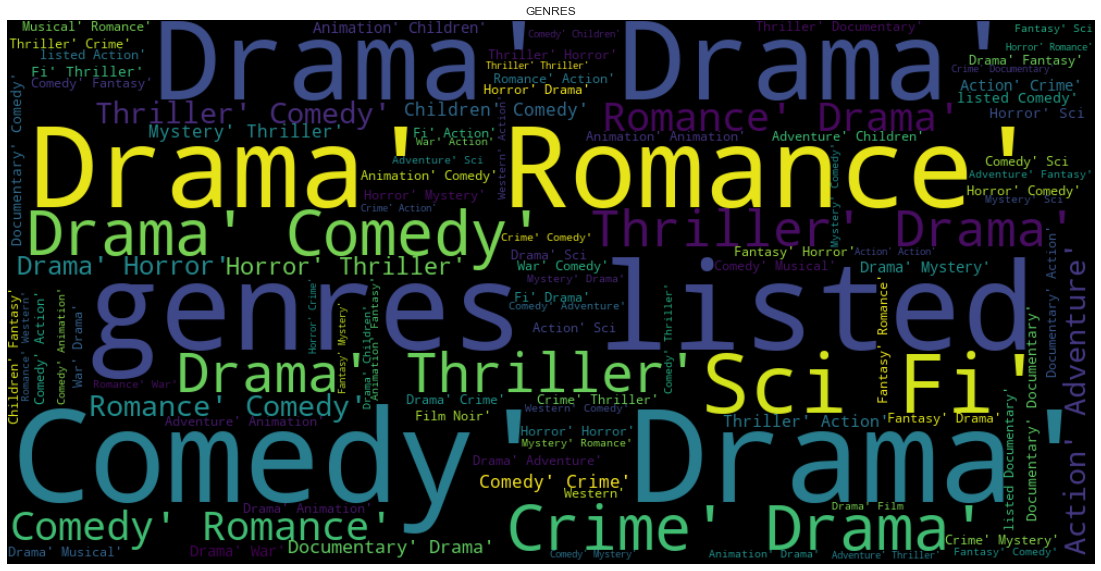

In [21]:
#word cloud for genre
all_words = "".join([str(i) for i in movies['genres']])
wordcloud = WordCloud(width=1000, height=500, random_state=21, max_font_size=200, max_words=100).generate(all_words)
plt.subplots(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('GENRES')
plt.show()

### **Cast**

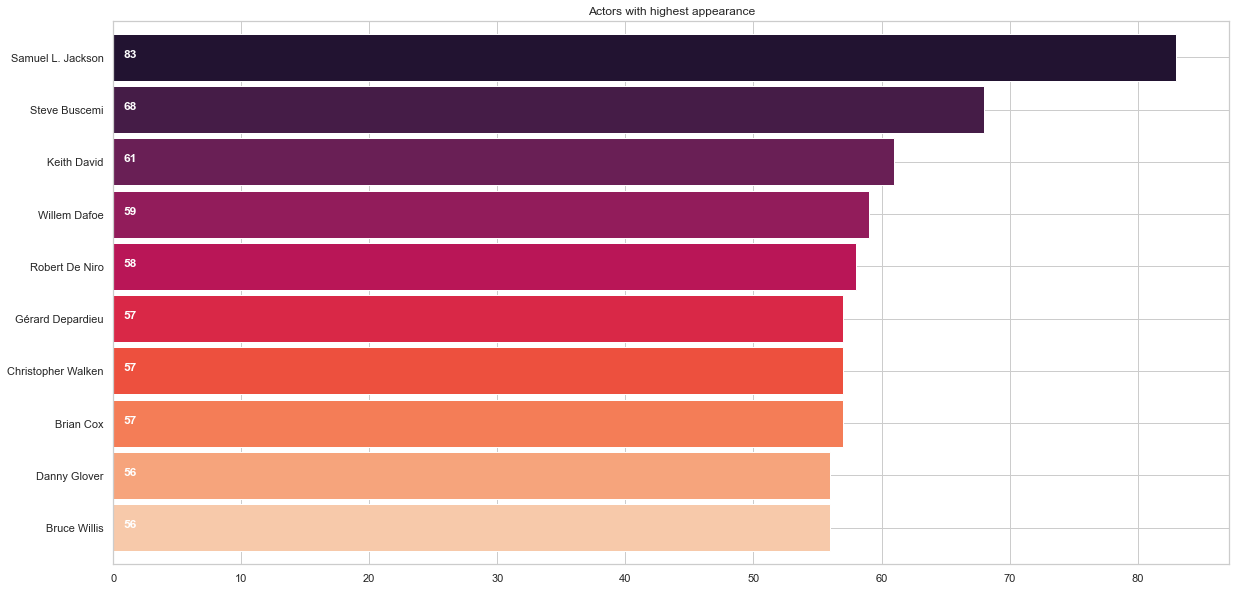

In [22]:
# Plot Distribution of Actors

plt.subplots(figsize=(20,10))
list1=[]
for i in imdb_data['title_cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[1:11].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('rocket_r',10))
for i, v in enumerate(pd.Series(list1).value_counts()[1:11].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

### **Wordloud - Cast**

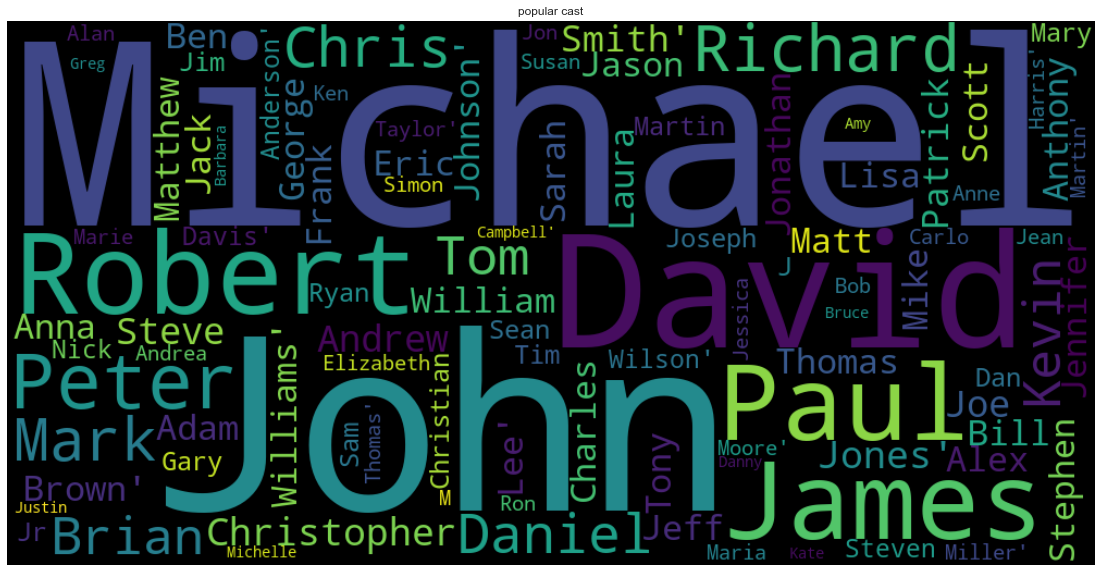

In [23]:
from PIL import Image
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#word cloud for key words that people use while searching
all_words = ''.join([str(i) for i in imdb_data['title_cast']])
wordcloud = WordCloud(width=1000, height=500, random_state=25, max_font_size=250, max_words=100).generate(all_words)
plt.subplots(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('popular cast')
plt.show()

### **Directors**

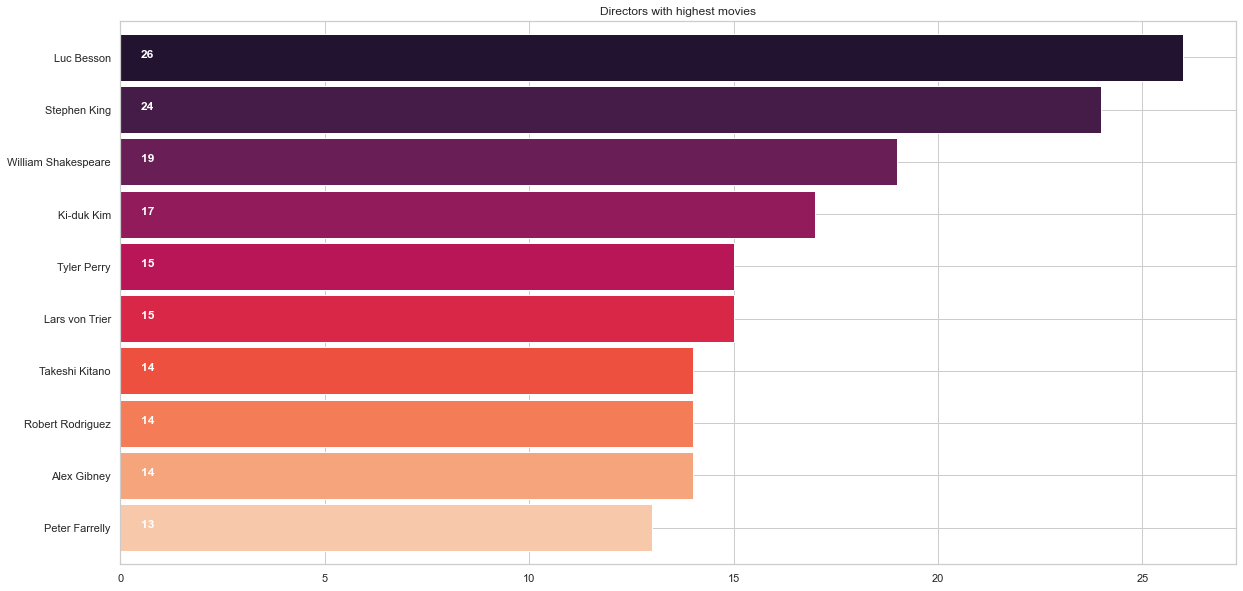

In [24]:
# Plot Distribution of Directors

def xstr(s):
    if s is None:
        return ''
    return str(s)
imdb_data['director'] = imdb_data['director'].apply(xstr)
plt.subplots(figsize=(20,10))
ax = imdb_data[imdb_data['director']!=''].director.value_counts()[2:12].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('rocket_r',10))
for i, v in enumerate(imdb_data[imdb_data['director']!=''].director.value_counts()[2:12].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()

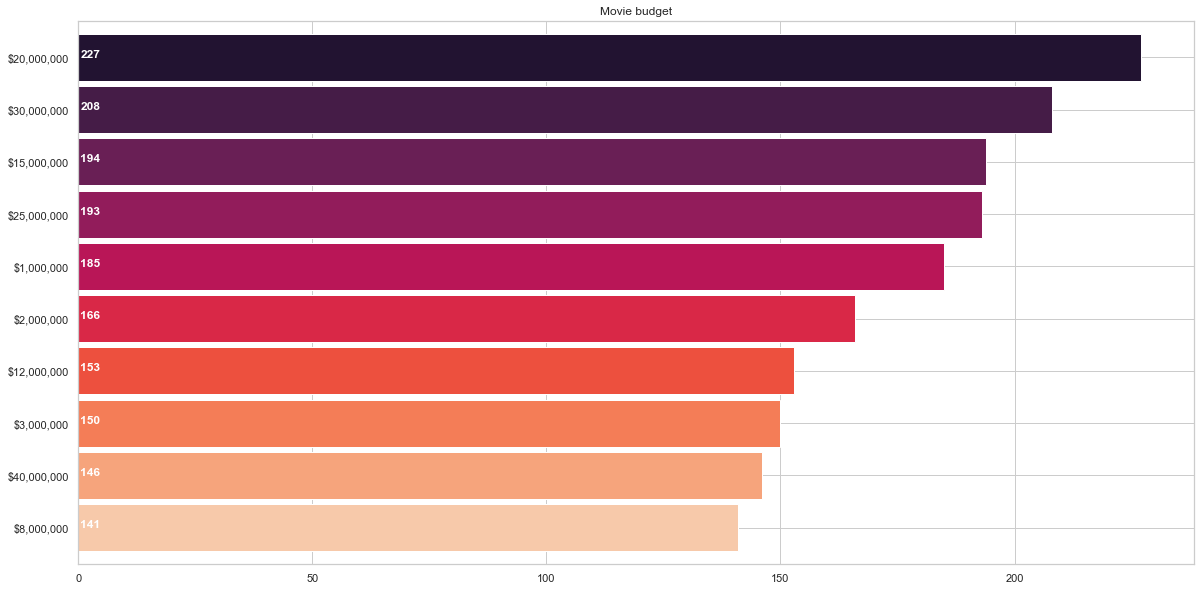

In [25]:

def xstr(s):
    if s is None:
        return ''
    return str(s)
imdb_data['budget'] = imdb_data['budget'].apply(xstr)
plt.subplots(figsize=(20,10))
ax = imdb_data[imdb_data['budget']!=''].budget.value_counts()[2:12].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('rocket_r',10))
for i, v in enumerate(imdb_data[imdb_data['budget']!=''].budget.value_counts()[2:12].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Movie budget')
plt.show()

### **Plot keywords**

In [26]:
# Create wordcloud of plot_keywords

cloud = ''
for i in imdb_data['plot_keywords']:
    for e in i:
        cloud += ' '+ str(e)

### **Ratings**

In [27]:
print (f'Number of ratings in dataset: {train_data.shape[0]}')

Number of ratings in dataset: 10000038


Average rating in dataset: 3.5333951730983424


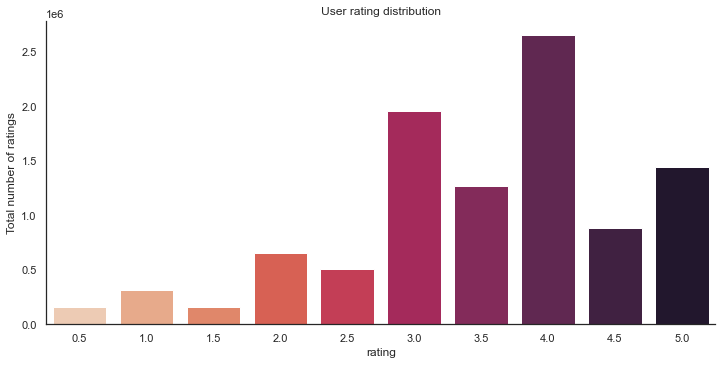

In [28]:
# Plot Distribution of Ratings

with sns.axes_style('white'):
    g = sns.factorplot('rating', data=train_data, aspect=2.0,kind='count',palette="rocket_r")
    g.set_ylabels('Total number of ratings')
    plt.title("User rating distribution")
print (f'Average rating in dataset: {np.mean(train_data["rating"])}')

In [29]:
#create a dataframe to count how many times each user has rated a movie
user_id = pd.DataFrame(train_data.groupby('userId')['rating'].mean())
user_id['total number of ratings'] = pd.DataFrame(train_data.groupby('userId')['rating'].count())
user_id.head(10)

,rating,total number of ratings
userId,,
1,3.910714,28
2,3.416667,72
3,3.691235,251
4,3.308989,89
5,3.885714,35
6,4.333333,9
7,4.000000,10
8,3.693548,62
9,3.900000,60


In [30]:
#Create new dataframe
user_id = pd.DataFrame(train_data.groupby('userId')['rating'].mean())
user_id['total number of ratings'] = pd.DataFrame(train_data.groupby('userId')['rating'].count())
# sort dataframe by total number of ratings
user_id.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
user_id.reset_index(inplace=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '72315'),
  Text(1, 0, '80974'),
  Text(2, 0, '137293'),
  Text(3, 0, '33844'),
  Text(4, 0, '20055'),
  Text(5, 0, '109731'),
  Text(6, 0, '49403'),
  Text(7, 0, '92046'),
  Text(8, 0, '110971'),
  Text(9, 0, '30879')])

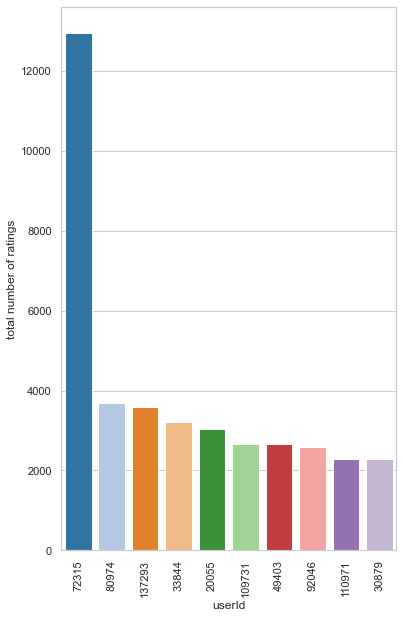

In [31]:
#total number of ratings per user id
sns.barplot(y="total number of ratings", x="userId", data=user_id.head(10), 
 order = user_id.head(10).sort_values('total number of ratings', ascending=False).userId, palette="tab20")
plt.xticks(rotation=90)

### **Joining dataFrames**

The data was provided in multiple csv files, the analysis of the data will be simpler and more efficiently carried out if the multiple files are joined to form one dataframe.

In [32]:
# Merge the train_data, movies & imdb_data into a joint dataframe

joint_df = train_data.merge(movies,on='movieId').merge(imdb_data,on='movieId')
joint_df.head(3)

,userId,movieId,rating,timestamp,title,genres,year,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"
1,87388,57669,3.5,1237455297,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"
2,137050,57669,4.0,1425631854,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"


In [33]:
#Create new dataframe
user_id = pd.DataFrame(joint_df.groupby('userId')['rating'].mean())
user_id['total number of ratings'] = pd.DataFrame(joint_df.groupby('userId')['rating'].count())
# sort dataframe by total number of ratings
user_id.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
user_id.reset_index(inplace=True)

In [34]:
# remove commas
joint_df['budget'] = joint_df['budget'].astype(str).str.replace(',', '')

# remove currency signs like "$" and "GBP"
joint_df['budget'] = joint_df['budget'].str.extract('(\d+)', expand=False)

# convert the feature into a float
joint_df['budget'] = joint_df['budget'].astype(float)

# remove nan values and replacing with 0
joint_df['budget'] = joint_df['budget'].replace(np.nan, 0)

# convert the feature into an integer
joint_df['budget'] = joint_df['budget'].astype(int)

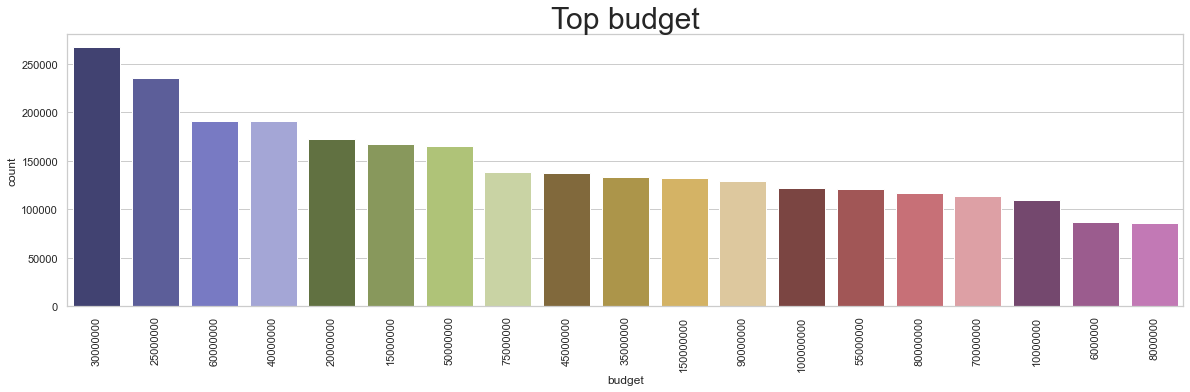

In [35]:
#Top budgets  
plt.figure(figsize = (20,5))
budget=joint_df['budget'].explode()
ax=sns.countplot(x=budget, order = budget.value_counts().index[1:20], palette="tab20b")
ax.set_title('Top budget',fontsize=30)
plt.xticks(rotation=90)
plt.show()

In [36]:
def correlation_matrix( df ):
    corr = df.corr()
    figure , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 20 , as_cmap = True )
    figure = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })

Text(0.5, 1.0, 'Correlation matrix')

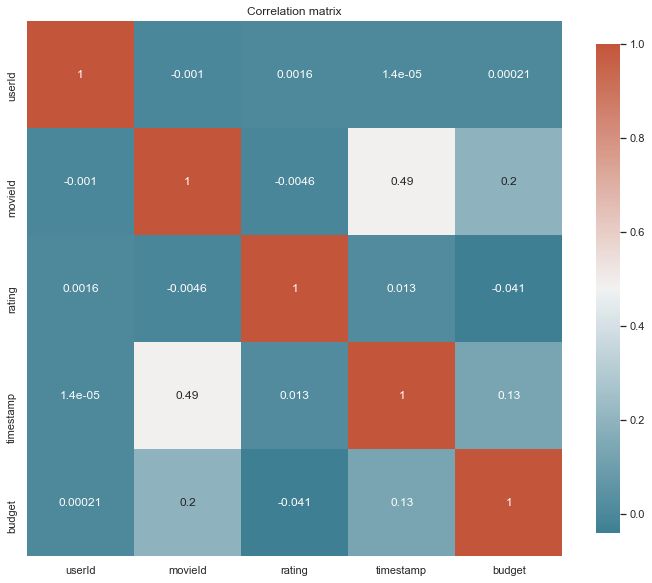

In [37]:
# Select a number of features from the dataframe to make the correlation map
joint1_df=joint_df
correlation_matrix(joint_df[['userId','movieId','rating', 'timestamp', 'budget','runtime']])
plt.title("Correlation matrix")

In [38]:
joint1_df['runtime'].describe()

count     9633031
unique        258
top              
freq      2653058
Name: runtime, dtype: object

Text(0.5, 1.0, 'Runtime distribution graph')

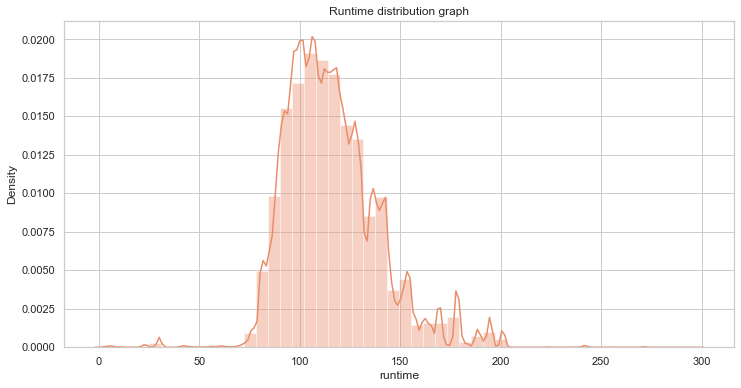

In [39]:
#convert runtime to numeric to be able to plot the graph
joint1_df['runtime']=pd.to_numeric(joint_df['runtime'])
plt.figure(figsize=(12,6))
sns.distplot(joint1_df[(joint1_df['runtime'] < 300) & (joint1_df['runtime'] > 0)]['runtime'])
plt.title("Runtime distribution graph")


In [40]:
#create a new dataframe
new1 = pd.DataFrame(joint_df.groupby('title')['rating'].mean())
new1['total number of ratings'] = pd.DataFrame(joint_df.groupby('title')['rating'].count())
# sort dataframe by total number of ratings
new1.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
new1.reset_index(inplace=True)

<AxesSubplot:xlabel='total number of ratings', ylabel='title'>

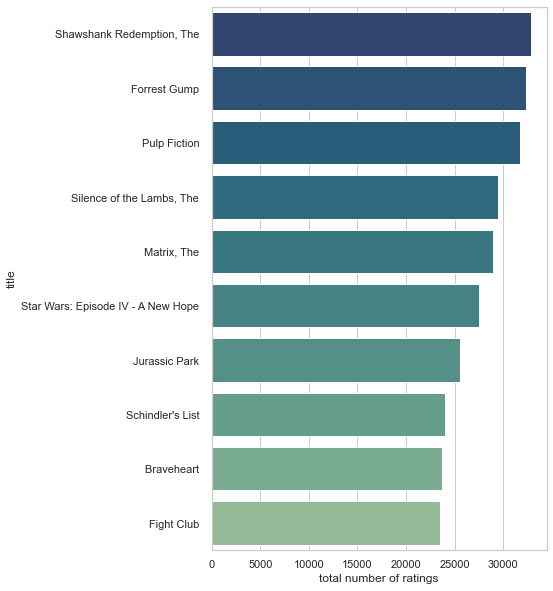

In [41]:
fig, ax = plt.subplots(figsize=(6, 10))

sns.barplot(x="total number of ratings", y="title", data=new1.head(10), palette='crest_r')

In [42]:
joint_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9633031 entries, 0 to 9633030
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   userId         int64  
 1   movieId        int64  
 2   rating         float64
 3   timestamp      int64  
 4   title          object 
 5   genres         object 
 6   year           object 
 7   title_cast     object 
 8   director       object 
 9   runtime        float64
 10  budget         int32  
 11  plot_keywords  object 
dtypes: float64(2), int32(1), int64(3), object(6)
memory usage: 918.7+ MB


In [43]:
joint_df.isnull().sum()

userId                 0
movieId                0
rating                 0
timestamp              0
title                  0
genres                 0
year                  26
title_cast             0
director               0
runtime          2653058
budget                 0
plot_keywords          0
dtype: int64

#### Some preprocessing needed for our Content-Based Recommender System.
- Change lists in columns to strings
- Removing of "noise" in our data.
    - Extract first two words from plot_keywords
    - Extract first two names/surnames from title_cast

In [44]:
joint_df.head(3)

,userId,movieId,rating,timestamp,title,genres,year,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,15000000,"[dwarf, bruges, irish, hitman]"
1,87388,57669,3.5,1237455297,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,15000000,"[dwarf, bruges, irish, hitman]"
2,137050,57669,4.0,1425631854,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,15000000,"[dwarf, bruges, irish, hitman]"


In [45]:
joint_df['genres'] = [''.join(map(str, l)) for l in joint_df['genres']]
joint_df['title_cast'] = [''.join(map(str, l)) for l in joint_df['title_cast']]
joint_df['plot_keywords'] = [''.join(map(str, l)) for l in joint_df['plot_keywords']]
joint_df.head()

,userId,movieId,rating,timestamp,title,genres,year,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges,ComedyCrimeDramaThriller,2008,Elizabeth BerringtonRudy BlommeOlivier Bonjour...,Martin McDonagh,107.0,15000000,dwarfbrugesirishhitman
1,87388,57669,3.5,1237455297,In Bruges,ComedyCrimeDramaThriller,2008,Elizabeth BerringtonRudy BlommeOlivier Bonjour...,Martin McDonagh,107.0,15000000,dwarfbrugesirishhitman
2,137050,57669,4.0,1425631854,In Bruges,ComedyCrimeDramaThriller,2008,Elizabeth BerringtonRudy BlommeOlivier Bonjour...,Martin McDonagh,107.0,15000000,dwarfbrugesirishhitman
3,120490,57669,4.5,1408228517,In Bruges,ComedyCrimeDramaThriller,2008,Elizabeth BerringtonRudy BlommeOlivier Bonjour...,Martin McDonagh,107.0,15000000,dwarfbrugesirishhitman
4,50616,57669,4.5,1446941640,In Bruges,ComedyCrimeDramaThriller,2008,Elizabeth BerringtonRudy BlommeOlivier Bonjour...,Martin McDonagh,107.0,15000000,dwarfbrugesirishhitman


In [46]:
# replace each plot_keywords observation, with only the first 2 words in the plot_keywords column
joint_df['plot_keywords'] = joint_df['plot_keywords'].str.extract('(^\w+\W\w+)')
# Then replace NaN values again with nulls a computer understands
joint_df['plot_keywords'] = joint_df['plot_keywords'].fillna('')

In [47]:
# replace each cast observation, with only the first 2 cast members
joint_df['title_cast'] = joint_df['title_cast'].str.extract('(^\w+\W\w+\W\w+\W\w+)')
# Then replace NaN values again with nulls a computer understands
joint_df['title_cast'] = joint_df['title_cast'].fillna('')

In [48]:
joint_df.head(3)

,userId,movieId,rating,timestamp,title,genres,year,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges,ComedyCrimeDramaThriller,2008,Elizabeth BerringtonRudy BlommeOlivier Bonjour...,Martin McDonagh,107.0,15000000,
1,87388,57669,3.5,1237455297,In Bruges,ComedyCrimeDramaThriller,2008,Elizabeth BerringtonRudy BlommeOlivier Bonjour...,Martin McDonagh,107.0,15000000,
2,137050,57669,4.0,1425631854,In Bruges,ComedyCrimeDramaThriller,2008,Elizabeth BerringtonRudy BlommeOlivier Bonjour...,Martin McDonagh,107.0,15000000,


<a id="six"></a>
## 6. Content Based Filtering
The content-based approach uses additional information about users and/or items. This filtering method uses item features to recommend other items similar to what the user likes and also based on their previous actions or explicit feedback.

We will use a content-based to make movie recommendations based on plot keywords, movie genres & the movie year. 
Note: Additional features such as director etc. can be added, if the computational power is avaiable.

1. Create Column with the chosen combined strings.
2. Extract original title data (no pre-processing).
3. Use CountVectorizer to vectorize the new combined column. (CountVectorize is a method used to turn text into a numeric representation)
4. Measure the cosine_similarity of the vectorized combined data.
5. Create a function that uses the similarity to recommend movies based on movie input.

In [49]:
# Concatenate columns into single column for vectorization
joint_df['combined'] = joint_df['year'] + joint_df['genres'] + joint_df['plot_keywords']

In [50]:
# Create new dataframe as a copy of the old, including a merge of an original movies dataframe - for title reference.
content_df = joint_df.merge(movies_og,on='movieId')
joint_df.head(3)

,userId,movieId,rating,timestamp,title,genres,year,title_cast,director,runtime,budget,plot_keywords,combined
0,5163,57669,4.0,1518349992,In Bruges,ComedyCrimeDramaThriller,2008,Elizabeth BerringtonRudy BlommeOlivier Bonjour...,Martin McDonagh,107.0,15000000,,2008ComedyCrimeDramaThriller
1,87388,57669,3.5,1237455297,In Bruges,ComedyCrimeDramaThriller,2008,Elizabeth BerringtonRudy BlommeOlivier Bonjour...,Martin McDonagh,107.0,15000000,,2008ComedyCrimeDramaThriller
2,137050,57669,4.0,1425631854,In Bruges,ComedyCrimeDramaThriller,2008,Elizabeth BerringtonRudy BlommeOlivier Bonjour...,Martin McDonagh,107.0,15000000,,2008ComedyCrimeDramaThriller


In [51]:
# Set the amount of data points to be used in the recommender system - where n = sample size
content_df = content_df.sample(n=35000)
# Set the index to movieId
content_df.set_index('movieId', inplace = True)
# Drop unnecessary columns that wont be used in the final system
content_df.drop(['userId','rating','timestamp', 'genres_x','year', 'title_cast','director','runtime','budget','plot_keywords', 'genres_y', 'title_x'],axis=1,inplace=True)
# View final dataframe for recommendation
content_df.head(3)

,combined,title_y
movieId,,
1920,1998AnimationChildrenFantasyWarchild gaggedpar...,Small Soldiers (1998)
1183,1996DramaRomanceWar,"English Patient, The (1996)"
2355,1998AdventureAnimationChildrenComedyantcircusa...,"Bug's Life, A (1998)"


In [52]:
def combined_cleaner(df, columns):
    
    """ Function takes in a dataframe & column, cleans it (as per below) and returns the cleaned dataframe"""
    
    for i in columns:
        df[i] = df[i].str.replace(',', '') # remove commas
        df[i] = df[i].str.lower() # lower case
        df[i] = df[i].str.replace(' ', '') # remove spaces
    return df

combined_cleaner(content_df, ['combined'])
content_df.head(3)

,combined,title_y
movieId,,
1920,1998animationchildrenfantasywarchildgaggedparo...,Small Soldiers (1998)
1183,1996dramaromancewar,"English Patient, The (1996)"
2355,1998adventureanimationchildrencomedyantcircusa...,"Bug's Life, A (1998)"


In [53]:
content_df.head(20)

,combined,title_y
movieId,,
1920,1998animationchildrenfantasywarchildgaggedparo...,Small Soldiers (1998)
1183,1996dramaromancewar,"English Patient, The (1996)"
2355,1998adventureanimationchildrencomedyantcircusa...,"Bug's Life, A (1998)"
626,1996comedyindependentfilmrevengedatingafrican,"Thin Line Between Love and Hate, A (1996)"
52328,2007adventuredramasci-fithriller,Sunshine (2007)
1221,1974crimedrama,"Godfather: Part II, The (1974)"
296,1994comedycrimedramathrillernonlineartimelineo...,Pulp Fiction (1994)
1,1995adventureanimationchildrencomedyfantasytoy...,Toy Story (1995)
3462,1936comedydramaromance,Modern Times (1936)


In [54]:
# save original titles
titles = content_df['title_y']

# save indexes of current dataframe
indices = pd.Series(content_df.index, index=content_df['title_y'])

In [55]:
# Vectorize the final column containing chosen features
cv = CountVectorizer()
cv_matrix = cv.fit_transform(content_df['combined'])

In [56]:
# Cosine Similarity Matrix
cos_sim = cosine_similarity(cv_matrix, cv_matrix)

In [57]:
def content_generate_top_N_recommendations(movie_title, N=10):
    
    """ Function takes in a movie title('s) & N, where N is equal to the amount of recommendations you'd like to view """
    
    idx=[]
    for i in movie_title:
        idx.append(indices[i])
        
    """ Function measures the similarity of the given titles with other titles"""
    
    sim_scores1 = list(enumerate(cos_sim[idx[0]]))
    #sim_scores2 = list(enumerate(cos_sim[idx[1]])) # Uncomment the code to the left to add second favourite movie to input
    #sim_scores3 = list(enumerate(cos_sim[idx[2]])) # Uncomment the code to the left to add third favourite movie to input
    sim_scores = sim_scores1# + sim_scores2 + sim_scores3 # Uncomment the code to the left, depending on movie title inputs chosen
    
    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N*2]
    movie_indices = [i[0] for i in sim_scores]
    movie_indices = np.setdiff1d(movie_indices, idx)
          
    # Convert the indexes back into titles 
    return titles.iloc[movie_indices[:10]]

In [58]:
# Generate N recommendations - Change value of N to change recommendations
content_generate_top_N_recommendations(['Gladiator (2000)'], N=10)

movieId
1183                   English Patient, The (1996)
2355                          Bug's Life, A (1998)
626      Thin Line Between Love and Hate, A (1996)
52328                              Sunshine (2007)
1221                Godfather: Part II, The (1974)
296                            Pulp Fiction (1994)
1                                 Toy Story (1995)
3462                           Modern Times (1936)
837                                 Matilda (1996)
1127                             Abyss, The (1989)
Name: title_y, dtype: object

<a id="seven"></a>
## 7. Collaborative Filtering
The Collaborative filtering method for recommender systems is a method that is solely based on the past interactions that have been recorded between users and items, in order to produce new recommendations. In essence, Collaborative Filtering looks at similarities between users.
- Matrix Factorization-based algorithms
    - Singular Value Decomposition (SVD)
    - Non-negative matrix factorization (NMF)
    - Slope One
    - Co-clustering
- k-Nearest Neighbors (KNN)
    - KNNBasic
    - KNNWithMeans
   
#### Data Used in Collaborative Filtering:
 - train data (for model training and evaluation).
 - test data (for submission).
 
We will we training numerous models on a sample of the data, due to computational limitations and comparing training time & RMSE score. We will then choose the best model and move to hyperparameter tuning. Hyperparameter Tuning will be used in collaboration with Comet, where we can view past results and the hyperparameters used, then proceed to choose the best hyperparameters. Final model will be used to predict user movie-ratings.

In [59]:
# Loading as Surprise dataframe
df_train = train_data.copy()

# Filter out movies that were rated less than or equal to 100
filter_movies = df_train['movieId'].value_counts() > 100
filter_movies = filter_movies[filter_movies].index.tolist()
df_new = df_train[(df_train['movieId'].isin(filter_movies))]

# Sample of the data - Change n to increase sample size.
df_train = df_new.sample(n=10000) 

reader = Reader()
# Data selected for model training.
data = Dataset.load_from_df(df_train[["userId", "movieId", "rating"]], reader)

In [60]:
# Split Data into test & train
trainset, testset = train_test_split(data, test_size=0.01, random_state = 42)

#### Singular Value Decomposition (SVD)
SVD is the most common method used in collaborative filtering recommender systems, it is a linear algebra factorization technique that decomposes a matrix into three matrices. SVD shrinks space dimensions from n-dimension to k-dimension (where k<n), thus reducing the number of features.

In [61]:
#Save model traning time
modeltime = time.time()

#Selecting and fitting the SVD model using the train_split set
svd = SVD()
svd.fit(trainset)

#Making predictions using the fitted model
svd_pred = svd.test(testset) 

#Checking the root mean squared error to get an idea of how well the model performs
svd_rmse = rmse(svd_pred)

#View model training time & rmse
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
svd_time = round(((time.time() - modeltime)),2)

RMSE: 1.0402
Model Runtime: 1.28 seconds


#### Non-negative matrix factorization (NMF)
Non-Negative Matrix Factorization uses techniques from multivariate analysis and linear algebra. It decomposes the data as a matrix M into the product of two lower ranking matrices W and H. The sub-matrix W contains the NMF basis; the sub-matrix H contains the associated coefficients (weights).

In [62]:
#Save model traning time
modeltime = time.time()

#Selecting and fitting the NMF model using the train_split set
nmf = NMF()
nmf.fit(trainset)

#Making predictions using the fitted model
nmf_pred = nmf.test(testset)

#Checking the root mean squared error to get an idea of how well the model performs
nmf_rmse = rmse(nmf_pred)

#View model training time & rmse
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
nmf_time = round(((time.time() - modeltime)),2)

RMSE: 1.0908
Model Runtime: 2.35 seconds


#### Slope One
The main idea of the algorithm is to create a linear relation between items preferences such as the relation F(x) = x + b. The name "Slope One" cames from the fact that here the "x" is multiplied by "1".

In [63]:
#Save model traning time
modeltime = time.time()

#Selecting and fitting the SlopeOne model using the train_split set
slope = SlopeOne()
slope.fit(trainset)

#Making predictions using the fitted model
slope_pred = slope.test(testset)

#Checking the root mean squared error to get an idea of how well the model performs
slope_rmse = rmse(slope_pred)

#View model training time & rmse
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
slope_time = round(((time.time() - modeltime)),2)

RMSE: 1.0852
Model Runtime: 0.45 seconds


#### Co-clustering
Co-clustering (or Biclustering) is a term in data mining that relates to a simultaneous clustering of the rows and columns of a matrix. Where classical clustering methods assume that a membership of an object (in a group of objects) depends solely on its similarity to other objects of the same type (same entity type), co-clustering can be seen as a method of co-grouping two types of entities simultaneously, based on similarity of their pairwise interactions.

In [64]:
#Save model traning time
modeltime = time.time()

#Selecting and fitting the CoClustering model using the train_split set
cc = CoClustering()
cc.fit(trainset)

#Making predictions using the fitted model
cc_pred = cc.test(testset)

#Checking the root mean squared error to get an idea of how well the model performs
cc_rmse = rmse(cc_pred)

#View model training time & rmse
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
cc_time = round(((time.time() - modeltime)),2)

RMSE: 1.0689
Model Runtime: 1.92 seconds


#### KNNBasic
KNNBasic is a basic collaborative filtering algorithm and is often used as a benchmark for more complex classifiers like the Support Vector Machines (SVM) and the Artificial Neural Networks (ANN).

In [65]:
#Save model traning time
modeltime = time.time()

#Selecting and fitting the KNNBasic model using the train_split set
knnb = KNNBasic()
knnb.fit(trainset)

#Making predictions using the fitted model
knnb_pred = knnb.test(testset) 

#Checking the root mean squared error to get an idea of how well the model performs
knnb_rmse = rmse(knnb_pred)

#View model training time & rmse
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
knnb_time = round(((time.time() - modeltime)),2)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0379
Model Runtime: 2.57 seconds


#### KNNWithMeans
KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

In [66]:
#Save model traning time
modeltime = time.time()

#Selecting and fitting the KNNWithMeans model using the train_split set
knnm = KNNWithMeans()
knnm.fit(trainset)

#Making predictions using the fitted model
knnm_pred = knnm.test(testset) 

#Checking the root mean squared error to get an idea of how well the model performs
knnm_rmse = rmse(knnm_pred)

#View model training time & rmse
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
knnm_time = round(((time.time() - modeltime)),2)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0852
Model Runtime: 2.64 seconds


<a id="eight"></a>
## 8. Evaluating Model Performances
 - Select best model for Hyperparameter Tuning and Submission.

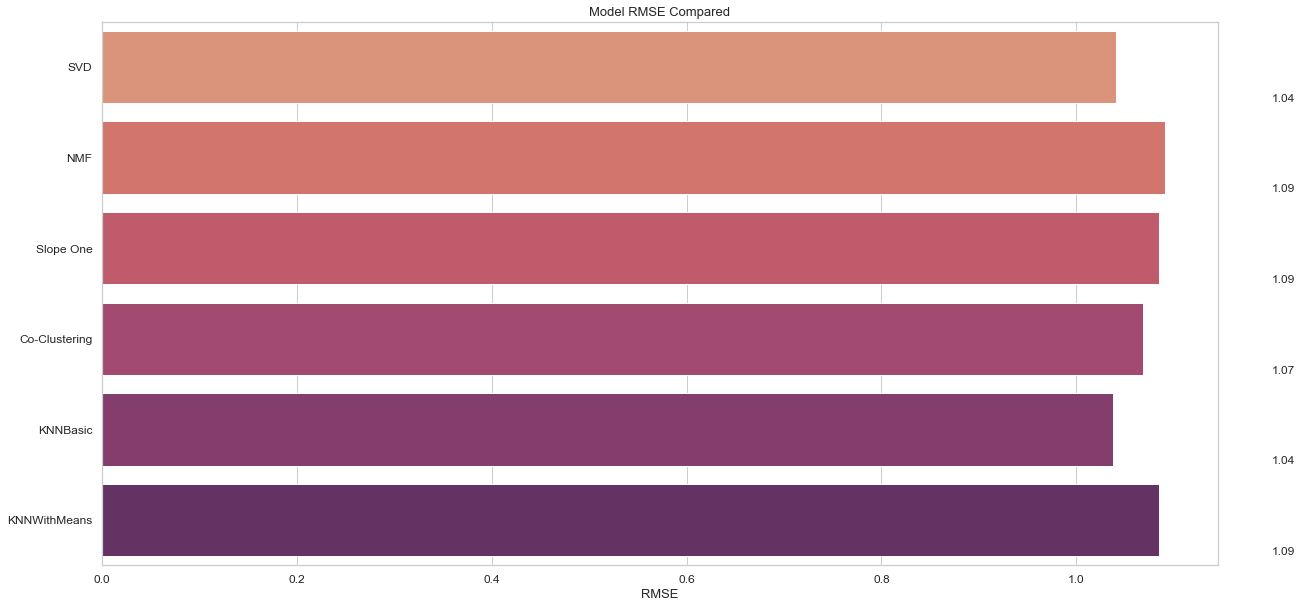

In [67]:
# Compare RMSE Between Models

fig,axis = plt.subplots(figsize=(20, 10))
rmse_y = ['SVD','NMF','Slope One', 'Co-Clustering', 'KNNBasic', 'KNNWithMeans']
rmse_x = [svd_rmse,nmf_rmse,slope_rmse, cc_rmse, knnb_rmse, knnm_rmse]
ax = sns.barplot(y=rmse_y, x=rmse_x,palette='flare')
plt.title('Model RMSE Compared',fontsize=13)
plt.xlabel('RMSE', size=13)
plt.yticks(size=12)
plt.xticks(size=12)
for i in ax.patches:
    ax.text(i.get_x() + i.get_height()*1.5, i.get_y() + i.get_height(), round(i.get_width(),2), fontsize=12, ha="left", va='bottom')
plt.show()

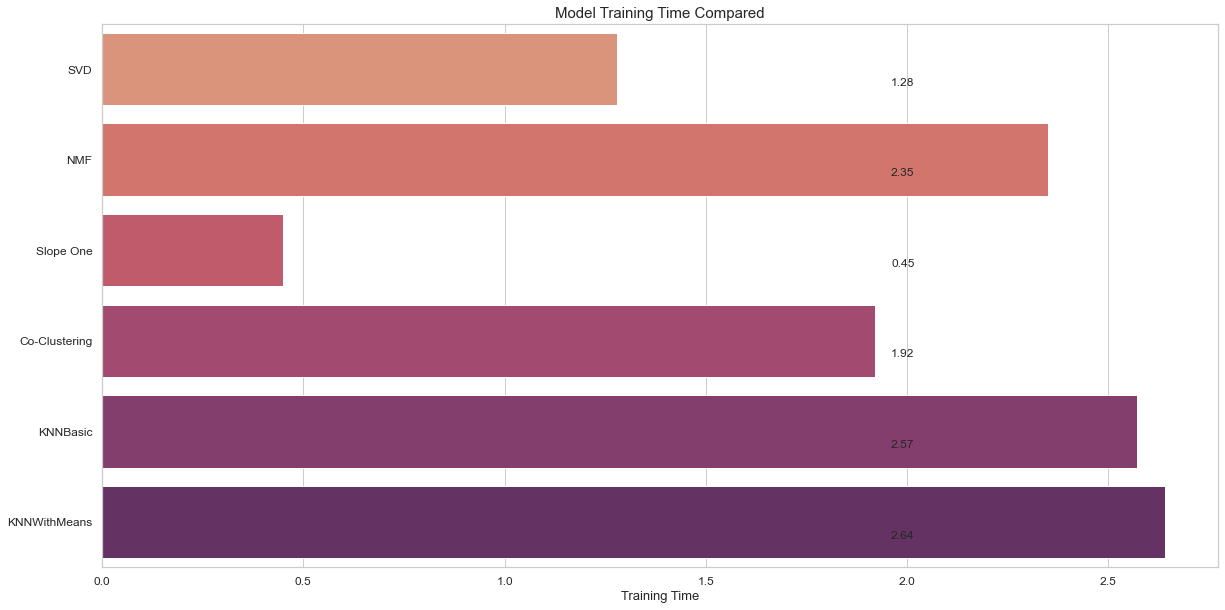

In [68]:
# Compare Training Times Between Models

fig,axis = plt.subplots(figsize=(20, 10))
rmse_y = ['SVD','NMF','Slope One', 'Co-Clustering', 'KNNBasic', 'KNNWithMeans']
rmse_x = [svd_time,nmf_time,slope_time, cc_time, knnb_time, knnm_time]
ax = sns.barplot(y=rmse_y, x=rmse_x,palette='flare')
plt.title('Model Training Time Compared',fontsize=15)
plt.xlabel('Training Time', size=13)
plt.yticks(size=12)
plt.xticks(size=12)
for i in ax.patches:
    ax.text(i.get_x() + i.get_height()*2.45, i.get_y() + i.get_height()-0.2, round(i.get_width(),2), fontsize=12, ha="left", va='bottom')
plt.show()

<a id="nine"></a>
## 9. Hyperparameter Tuning
 - Hyperparameter Tuning of Best performing Model - SVD.
 - In collaboration with Comet.

In [ ]:
# Remove the line of code below to hyperparameter tune on all data.
df_train = df_train.sample(n=10000)

train_data = Dataset.load_from_df(df_train[["userId", "movieId", "rating"]], reader = Reader())
trainset = train_data.build_full_trainset()

# Select hyperparameters to be included in the GridSearch to find optimal.
param_grid = {'n_epochs': [30, 35, 40, 45, 50, 55, 60, 65],
'n_factors': [50, 150, 300, 400],
'lr_all': [0.001, 0.003, 0.004, 0.005],
'reg_all': [0.005, 0.01, 0.02, 0.4, 0.5, 0.8]}

# Apply GridSearchCV & fit to chosen data
svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
svd.fit(df_train)

# Prints best hyperparameters
print("Best Parameters", svd.best_params['rmse'])

In [ ]:
# Log best parameters & RMSE score to Comet
params = svd.best_params['rmse']
rmse = svd.best_score['rmse']


# Uncomment the below to save results to comet
experiment.log_parameters(params)
experiment.log_metric('rmse', rmse)

# End the experiment
experiment.end()

<a id="ten"></a>
## 10. Conculsion

Firstly, we used **Content-Based filtering** to give a user a list of recommendations based on the movie input data. The recommender uses the similarity between movies to recommend a movie the user might like.

Next we decided to use **Collaborative Filtering** to create a recommender model able to accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences, as per the initial problem statement. With regarding Collaborative Filtering, we used numerous models and **compared RMSE and the training times**, which resulted in **Singular Value Decomposition (SVD)** outperforming the rest of the models.

Trained SVD on all the data, moved to hyperparameter tuning, which we used in collaboration with Comet thus enabling us to do numerous hyperparameter experiments and choose the best possible hyperpameters, which gave us a model which is able to accurately predict movie ratings.

**Best Performing Parameters** {'n_epochs': 55, 'n_factors': 150, 'lr_all': 0.0065, 'reg_all': 0.01}

**Final Kaggle Score** 0.79842

<a id="eleven"></a>
## 11. Submission
- For kaggle challenge only.
- Use trained model to predict Ratings in the Test Data.

In [ ]:
# Make Predictions
ratings_predictions=[svd.predict(row.userId, row.movieId) for _,row in test_data.iterrows()]

In [ ]:
df_pred=pd.DataFrame(ratings_predictions)
df_pred=df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
df_pred.drop(['r_ui','details'],axis=1,inplace=True)

In [ ]:
df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

In [ ]:
df_pred.head()

In [ ]:
df_pred.drop(['userId', 'movieId'], inplace=True, axis= 1)
df_pred = df_pred[['Id', 'rating']]

In [ ]:
# Export the submission to CSV
df_pred.to_csv("submission.csv", index=False)